# Mean Sea Surface Temperature

https://www.ncei.noaa.gov/products/optimum-interpolation-sst

In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys
import os
import os.path as op

import xarray as xr
import plotly.express as px
import geopandas as gpd
import pandas as pd
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../../../../indicators_setup")
from ind_setup.plotting import plot_base_map, plot_bar_probs, plot_map_subplots, add_oni_cat
from ind_setup.plotting_int import plot_timeseries_interactive, plot_oni_index_th

sys.path.append("../../../functions")
from data_downloaders import download_oni_index



In [2]:

lon_site, lat_site = 134.368203, 7.322074

#Area of interest
lon_range  = [129.4088, 137.0541]
lat_range = [1.5214, 11.6587]

In [3]:
shp_f = op.join(os.getcwd(), '..', '..','..', 'data/Palau_EEZ/pw_eez_pol_april2022.shp')
shp_eez = gpd.read_file(shp_f)

In [4]:
path_data = "../../../data"
path_figs = "../../../matrix_cc/figures"
data = xr.load_dataset(op.join(path_data, 'sst_daily_1981_2024_palau.nc'))

In [5]:
dataset_id = 'sst'

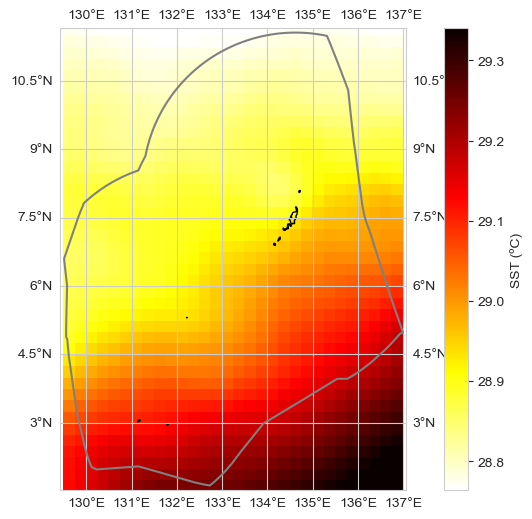

In [6]:
ax = plot_base_map(shp_eez = shp_eez, figsize = [10, 6])
im = ax.pcolor(data.lon, data.lat, data.mean(dim='time')[dataset_id], transform=ccrs.PlateCarree(), 
                cmap = 'hot_r', vmin = np.percentile(data.mean(dim = 'time')[dataset_id], 1), 
                vmax = np.percentile(data.mean(dim = 'time')[dataset_id], 99))
ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]], crs=ccrs.PlateCarree())
plt.colorbar(im, ax=ax, label='SST (ºC)')

plt.savefig(op.join(path_figs, 'F12_SST_map.png'), dpi=300, bbox_inches='tight')


#### Annual average

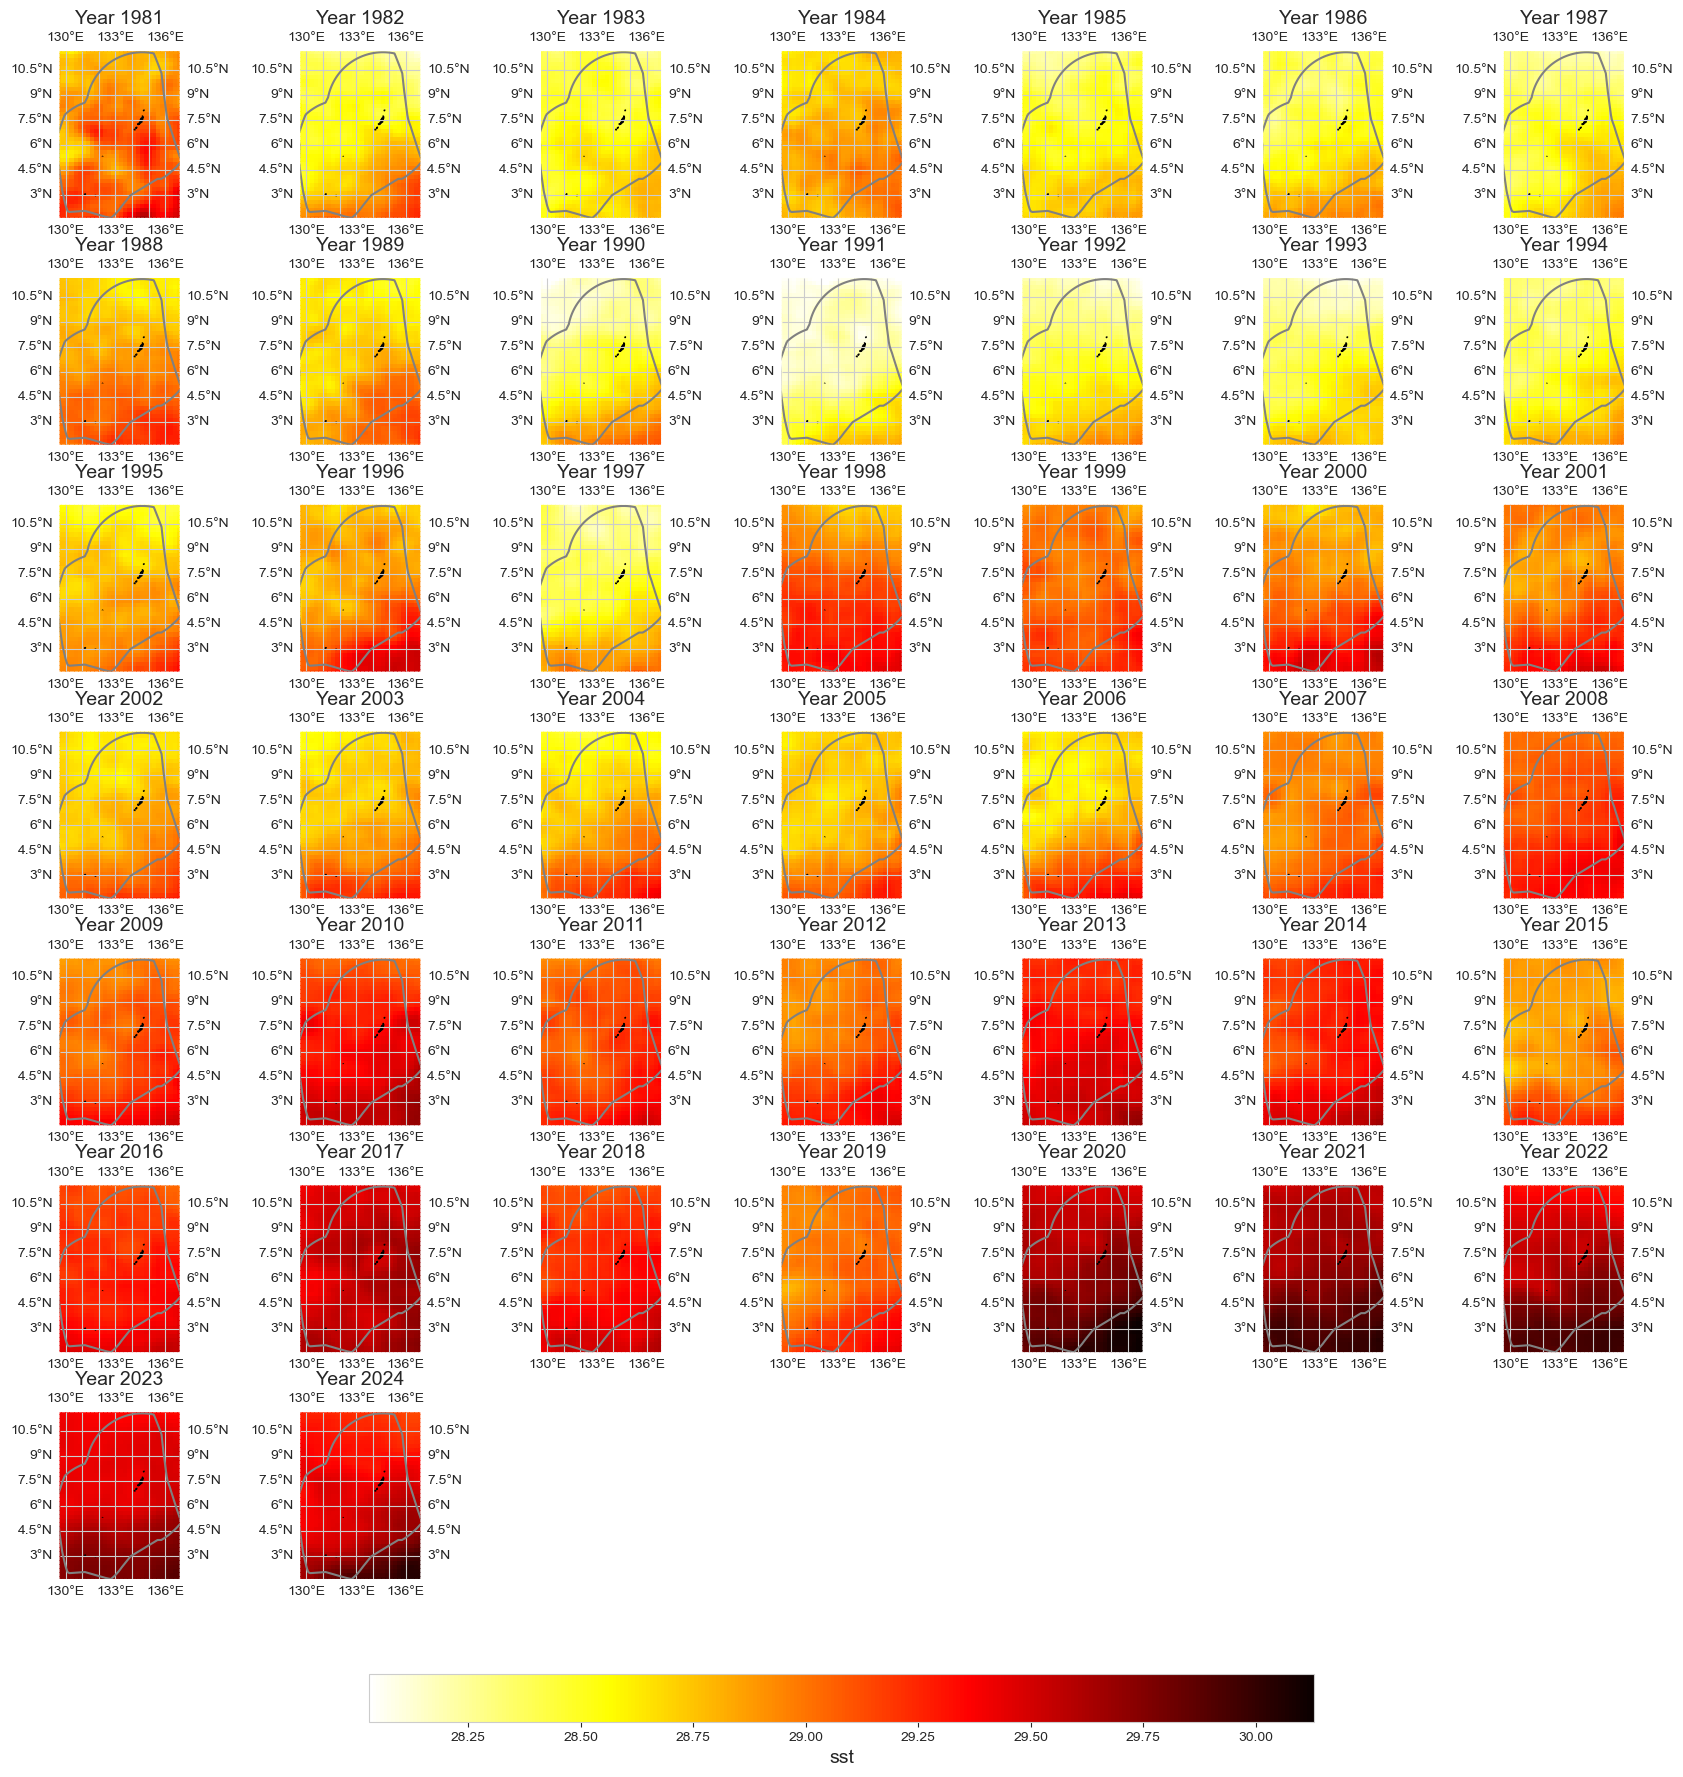

In [7]:
data_y = data.resample(time='1YE').mean()
im = plot_map_subplots(data_y, dataset_id, shp_eez = shp_eez, cmap = 'hot_r', 
                  vmin = np.nanpercentile(data_y.min(dim = 'time')[dataset_id], 1), 
                  vmax = np.nanpercentile(data_y.max(dim = 'time')[dataset_id], 99),
                  cbar = 1, cbar_pad = 0.05)

#### Annual anomaly

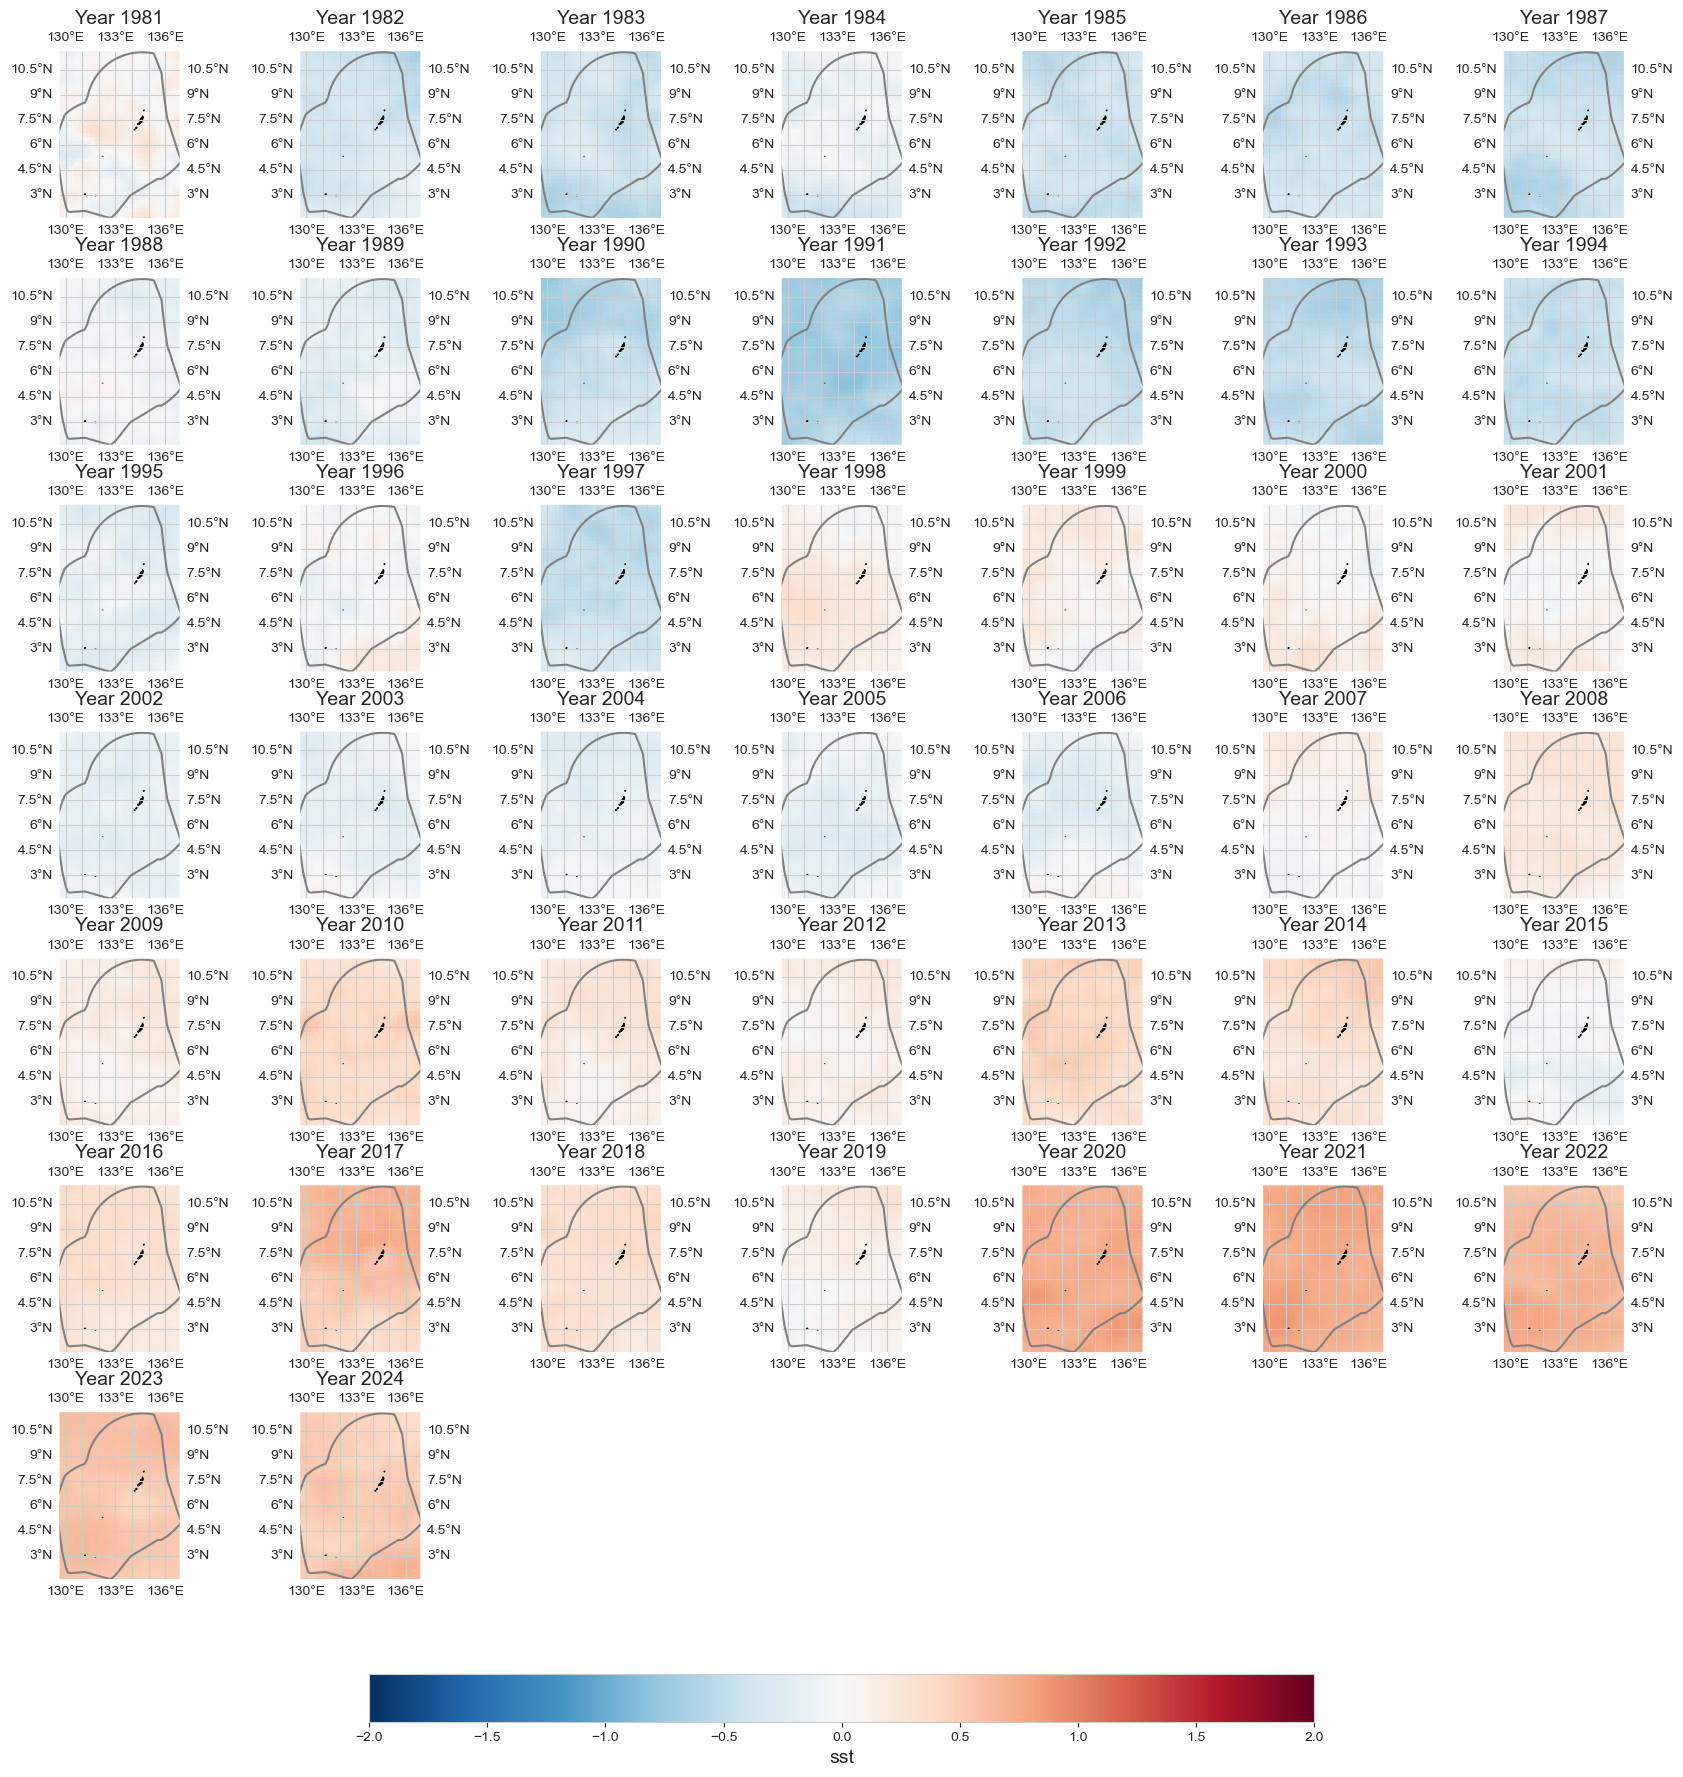

In [8]:
data_an = data_y - data.mean(dim='time')
fig = plot_map_subplots(data_an, dataset_id, shp_eez = shp_eez, cmap='RdBu_r',
                        vmin=-2, vmax=2, cbar = 1, cbar_pad = 0.05)

## Average Area

In [9]:
data_mean = data.mean(dim = ['lon', 'lat']).to_dataframe()
datag = data_mean.groupby(data_mean.index.year).max()
datag.index = pd.to_datetime(datag.index, format = '%Y')
datag['sst_ref'] = datag['sst'] - datag.loc['1961':'1990'].sst.mean()

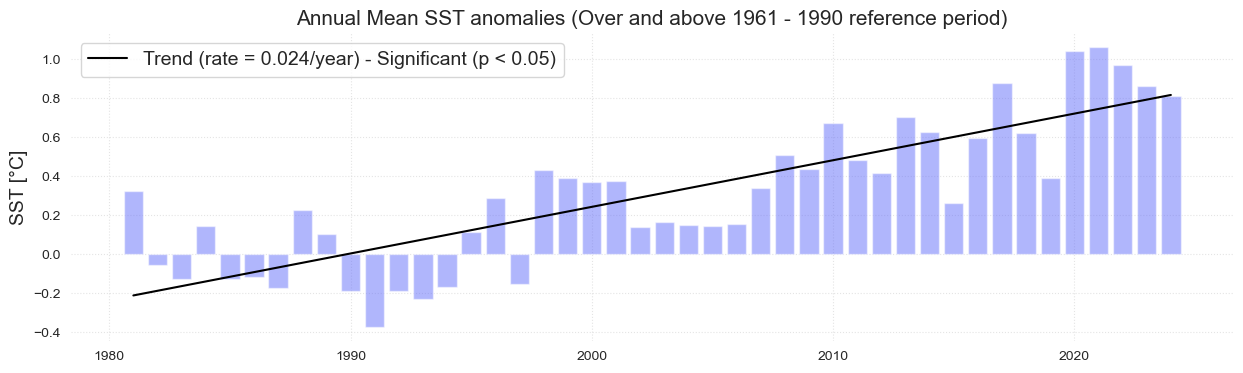

In [10]:
data_mean = data.mean(dim = ['lon', 'lat']).to_dataframe()
data_mean = data_mean.resample('YE').mean()
data_mean['sst_ref'] = data_mean['sst'] - data_mean.loc['1961':'1990'].sst.mean()
fig, ax, trend = plot_bar_probs(x=data_mean.index.year, y=data_mean.sst_ref, trendline=True,
                                y_label='SST [°C]', figsize=[15, 4], return_trend=True)
ax.set_title('Annual Mean SST anomalies (Over and above 1961 - 1990 reference period)', fontsize=15);
plt.savefig(op.join(path_figs, 'F12_SST_trends_Annomalies.png'), dpi=300, bbox_inches='tight')


## Given point

In [11]:
loc = [7.37, 134.7]
dict_plot = [{'data' : data.sel(lon=loc[1], lat=loc[0], method='nearest').to_dataframe(), 
              'var' : dataset_id, 'ax' : 1, 'label' : 'SST [ºC]'},]

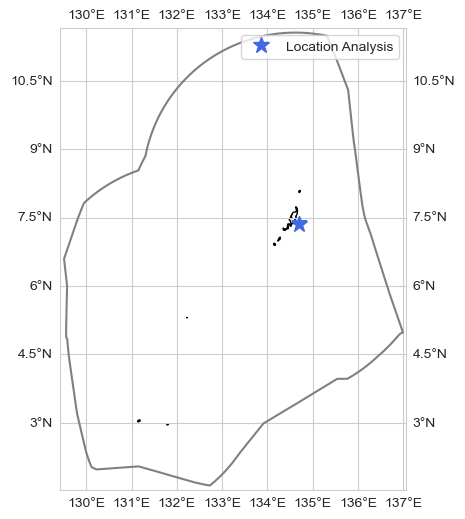

In [12]:
ax = plot_base_map(shp_eez = shp_eez, figsize = [10, 6])
ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]], crs=ccrs.PlateCarree())
ax.plot(loc[1], loc[0], '*', markersize = 12, color = 'royalblue', transform=ccrs.PlateCarree(), label = 'Location Analysis')
ax.legend()

In [13]:
fig = plot_timeseries_interactive(dict_plot, trendline=True, scatter_dict = None, figsize = (25, 12), label_yaxes = 'SST [ºC]');

### ONI index analysis

In [14]:
p_data = 'https://psl.noaa.gov/data/correlation/oni.data'
df1 = download_oni_index(p_data)

In [15]:
lims = [-.5, .5]
plot_oni_index_th(df1, lims = lims)

Group by ONI category

In [16]:
data_xr['ONI'] = (('time'), df1.iloc[np.intersect1d(data_xr.time, df1.index, return_indices=True)[2]].ONI.values)
data_xr['ONI_cat'] = (('time'), np.where(data_xr.ONI < lims[0], -1, np.where(data_xr.ONI > lims[1], 1, 0)))
data_oni = data_xr.groupby('ONI_cat').mean()
data_oni['labels'] = (('ONI_cat'),['La Niña', 'Neutral', 'El Niño'])

NameError: name 'data_xr' is not defined

In [ ]:
dataset_id = 'sst'

In [ ]:
fig = plot_map_subplots(data_oni, dataset_id, shp_eez = shp_eez, cmap = 'hot_r', 
                  vmin = np.percentile(data_xr.mean(dim = 'time')[dataset_id], 0) - .25, 
                  vmax = np.percentile(data_xr.mean(dim = 'time')[dataset_id], 100) + .25,
                  sub_plot= [1, 3], figsize = (15, 8), cbar = True, cbar_pad = .1)

plt.savefig(op.join(path_figs, 'F14_SST_ENSO.png'), dpi=300, bbox_inches='tight')


In [ ]:
data_an = data_oni - data_xr.mean(dim='time')
data_an['labels'] = (('ONI_cat'),['La Niña', 'Neutral', 'El Niño'])
fig = plot_map_subplots(data_an, dataset_id, shp_eez = shp_eez, cmap='RdBu_r', vmin=-.4, vmax=.4,
                  sub_plot= [1, 3], figsize = (15, 8), cbar = True, cbar_pad = 0.1)